# Assignment 2 - Restaurant and Consumer datasets
---

## Importing the data

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline

In [2]:
accepts = pd.read_csv('data/chefmozaccepts.csv')
restaurant_cuisine = pd.read_csv('data/chefmozcuisine.csv')
restaurant_hours = pd.read_csv('data/chefmozhours4.csv', names=['placeID', 'hours', 'days'])
restaurant_parking = pd.read_csv('data/chefmozparking.csv')
geoplaces = pd.read_csv('data/geoplaces2.csv', encoding='latin1')
rating = pd.read_csv('data/rating_final.csv')
user_cuisine = pd.read_csv('data/usercuisine.csv')
user_payment = pd.read_csv('data/userpayment.csv')
user_profile = pd.read_csv('data/userprofile.csv')

---
## Cleaning the data

In this section, I will be using the methods below. The fisrt one replaces all the strings by their lowercase representation so as to group related names, and then replaces missing values by Numpy's NaN. The second one computes the ratio of missing values for every column of a DataFrame. The third one returns all rows having unavailable values.

So as to not perform a lot of useless operations, I will only fill missing values needed to answer the questions.

In [3]:
def clean(df):
    df = df.applymap(lambda x:x.lower() if type(x) == str else x)
    df.replace(to_replace=['?', 'none'], value=np.nan, inplace=True)
    return df

In [4]:
def columns_na_ratio(df):
    return (df.isna().sum() / len(df.index)).round(3)

In [5]:
def get_empty_rows(df):
    return df[df.isnull().any(axis=1)]

### Geoplaces

First of all, let's clean the geographical dataset by dropping useless columns and then checking if it contains any duplicate rows.

In [6]:
geoplaces.drop(columns=['the_geom_meter', 'fax', 'zip', 'url'], inplace=True)
geoplaces = clean(geoplaces)
print(geoplaces.duplicated().sum(), "duplicated rows")

0 duplicated rows


This dataset has no duplicated rows, now let's group all unavailable values for each column and check if some columns aren't worth looking at.

In [7]:
columns_na_ratio(geoplaces)

placeID           0.000
latitude          0.000
longitude         0.000
name              0.000
address           0.208
city              0.138
state             0.138
country           0.215
alcohol           0.000
smoking_area      0.538
dress_code        0.000
accessibility     0.000
price             0.000
Rambience         0.000
franchise         0.000
area              0.000
other_services    0.915
dtype: float64

In [8]:
geoplaces['country'].value_counts()

mexico    102
Name: country, dtype: int64

We can see that 'other services' contains more than 90% of unkwown values, so let's drop this column. We are also going to drop 'latitude', 'longitude', 'dress_code', 'franchise', 'accessibility' columns as we are not going to use them. We might as well drop the 'country' columns, as it contains either 'mexico' or unavailable data. 

In [9]:
geoplaces.drop(columns=['latitude', 'longitude', 'country', 'other_services', 'dress_code', 'franchise', 'accessibility'], inplace=True)

We need to address the missing values in the 'smoking_area' column. To do so we will assume that most of the time, this column was not filled because restaurants assumed it would mean 'not permitted'.

In [10]:
geoplaces.fillna({'smoking_area':'not permitted'}, inplace=True)

Although there is no reasonable way to fill missing values for the 'address' column, we can clean the 'city' column a bit by replacing all variations of the same city together.

In [11]:
geoplaces['city'].value_counts()

san luis potosi     69
cuernavaca          16
victoria            10
jiutepec             4
soledad              2
victoria             2
ciudad victoria      2
cd victoria          1
slp                  1
s.l.p.               1
cd. victoria         1
san luis potos       1
san luis potosi      1
s.l.p                1
Name: city, dtype: int64

In [12]:
geoplaces.replace(to_replace=r'san luis.*|slp|s.l.p.*', value='san luis potosi', regex=True, inplace=True)
geoplaces.replace(to_replace=r'.*victoria.*', value='victoria', regex=True, inplace=True)

In [13]:
geoplaces['city'].value_counts()

san luis potosi    74
cuernavaca         16
victoria           16
jiutepec            4
soledad             2
Name: city, dtype: int64

Finally, we will fill unavailable data in the 'city' column by filling it with 'unknown', because we will need it in question 10.

In [14]:
geoplaces.fillna({'city':'unknown'}, inplace=True)

### User profile

In [15]:
user_profile = clean(user_profile)
print(user_profile['userID'].duplicated().sum(), "duplicated users")
columns_na_ratio(user_profile)

0 duplicated users


userID              0.000
latitude            0.000
longitude           0.000
smoker              0.022
drink_level         0.000
dress_preference    0.036
ambience            0.043
transport           0.051
marital_status      0.029
hijos               0.080
birth_year          0.000
interest            0.217
personality         0.000
religion            0.217
activity            0.051
color               0.000
weight              0.000
budget              0.051
height              0.000
dtype: float64

We made sure that each row represents a different user, as there are no duplicated userID.
We can drop 'interest' and 'religion' columns as they both have 20% unknown values and we won't be using them in the questions. Same as before, we won't be using 'latitude' and longitude' of this DataFrame. Some other columns we won't be using are 'color', 'weight', 'height', 'personality', 'ambience' and 'dress_preference'.

In [16]:
user_profile.drop(columns=['latitude', 'longitude', 'interest', 'religion', 'color', 'weight', 
                           'height', 'personality', 'dress_preference'], inplace=True)

We need to address the missing values in the 'hijos', 'transport', 'activity', 'smoker' and 'budget' columns. We will do so by replacing unavailable values by the most represented value in this column.

In [17]:
user_profile['hijos'].value_counts()

independent    113
kids            11
dependent        3
Name: hijos, dtype: int64

In [18]:
user_profile['transport'].value_counts()

public       82
car owner    35
on foot      14
Name: transport, dtype: int64

In [19]:
user_profile['activity'].value_counts()

student          113
professional      15
unemployed         2
working-class      1
Name: activity, dtype: int64

In [20]:
user_profile['budget'].value_counts()

medium    91
low       35
high       5
Name: budget, dtype: int64

In [21]:
user_profile['smoker'].value_counts()

false    109
true      26
Name: smoker, dtype: int64

In [22]:
user_profile.fillna({'hijos':'independent', 'transport':'public', 'activity':'student', 'budget':'medium', 'smoker':'false'}, inplace=True)

In [23]:
columns_na_ratio(user_profile)

userID            0.000
smoker            0.000
drink_level       0.000
ambience          0.043
transport         0.000
marital_status    0.029
hijos             0.000
birth_year        0.000
activity          0.000
budget            0.000
dtype: float64

This DataFrame is now suitable for calculations.

### User payments

In [24]:
user_payment = clean(user_payment)
print(user_payment.duplicated().sum(), "duplicated rows")
print(user_payment['userID'].duplicated().sum(), "multiple payments for single users")
columns_na_ratio(user_payment)

0 duplicated rows
44 multiple payments for single users


userID      0.0
Upayment    0.0
dtype: float64

This DataFrame is already clean, with no missing value and no duplicated rows. It is important to note that some clients have multiple means of payment.

## User cuisine

In [25]:
user_cuisine = clean(user_cuisine)
print(user_cuisine.duplicated().sum(), "duplicated rows")
columns_na_ratio(user_cuisine)

0 duplicated rows


userID      0.0
Rcuisine    0.0
dtype: float64

This DataFrame is already clean. There is not any question is related to it, so it won't be used any further.

## Rating

In [26]:
rating = clean(rating)
print(rating.duplicated().sum(), "duplicated rows")
columns_na_ratio(rating)

0 duplicated rows


userID            0.0
placeID           0.0
rating            0.0
food_rating       0.0
service_rating    0.0
dtype: float64

This DataFrame is already clean.

## Restaurant Hours

In [27]:
restaurant_hours = clean(restaurant_hours)
print(restaurant_hours.duplicated().sum(), "duplicated rows")
columns_na_ratio(restaurant_hours)

271 duplicated rows


placeID    0.0
hours      0.0
days       0.0
dtype: float64

This DataFrame has a lot of duplicated rows, let's remove them.

In [28]:
restaurant_hours.drop_duplicates(inplace=True)
print(restaurant_hours.duplicated().sum(), "duplicated rows")

0 duplicated rows


## Restaurant Cuisine

In [29]:
restaurant_cuisine = clean(restaurant_cuisine)
print(restaurant_cuisine.duplicated().sum(), "duplicated rows")
print(restaurant_cuisine['placeID'].duplicated().sum(), "duplicated restaurants")
columns_na_ratio(restaurant_cuisine)

0 duplicated rows
147 duplicated restaurants


placeID     0.0
Rcuisine    0.0
dtype: float64

There are no duplicated rows and this DataFrame is already clean. It is important to note that some restaurants offer multiple types of cuisine.

## Restaurant Parking

In [30]:
columns_na_ratio(restaurant_parking)

placeID        0.0
parking_lot    0.0
dtype: float64

In [31]:
restaurant_parking['parking_lot'].value_counts()

none                 348
yes                  174
public               102
street                32
fee                   22
valet parking         21
validated parking      3
Name: parking_lot, dtype: int64

First of all, we can see a limitation to the cleaning method we have bee using so far. In this DataFrame, 'none' means that there is no parking, not that the data is unavailable. As the names are already in lower case and there are no missing values, we will keep this DataFrame as is.

In [32]:
print(restaurant_parking.duplicated().sum(), "duplicated rows")
print(restaurant_parking[restaurant_parking.duplicated(subset='placeID', keep=False)]['placeID'].nunique(), 'restaurants have multiple parkings')

0 duplicated rows
26 restaurants have multiple parkings


As we have observed before, this DataFrame does not contain duplicated rows but some restaurants offer multiple types of parking.

## Payments Accepted

In [33]:
accepts = clean(accepts)
print(accepts.duplicated().sum(), "duplicated rows")
columns_na_ratio(accepts)

0 duplicated rows


placeID     0.0
Rpayment    0.0
dtype: float64

This DataFrame does not require cleaning.

---
## Questions - Part 1

**Question 1**
What are the names of different restaurants in the state of 'tamaulipas' ?

In [34]:
geoplaces[geoplaces['state'] == 'tamaulipas']['name']

3             little pizza emilio portes gil
4                              carnitas_mata
6                         taqueria el amigo 
8                   pollo_frito_buenos_aires
19                            tacos el guero
41                    hamburguesas la perica
73                                palomo tec
76                        tacos correcaminos
86             carreton de flautas y migadas
89                        gorditas dona tota
94                             little cesarz
103    carnitas mata  calle 16 de septiembre
106                       puesto de gorditas
109    carnitas mata calle emilio portes gil
122                                tacos abi
123                    la perica hamburguesa
Name: name, dtype: object

**Question 2**
How many different customers used public transport for going to the
restaurants ?

For this question, I assume each entry in 'user profile' is someone who actually went to the restaurants, as this dataset is collected from people going to restaurants.

In [35]:
user_profile['transport'].value_counts()

public       89
car owner    35
on foot      14
Name: transport, dtype: int64

We see that 89 customers used public transport. This value is influenced by the choice we made when filling unavailable values for this column.

**Question 3** What is the least popular payment method among customers ?


In [36]:
user_payment['Upayment'].value_counts()

cash                   131
bank_debit_cards        22
visa                    17
mastercard-eurocard      4
american_express         3
Name: Upayment, dtype: int64

In [37]:
user_payment[user_payment['Upayment'] == 'american_express'].count() / user_payment.count()

userID      0.016949
Upayment    0.016949
dtype: float64

The american express is the least popular payment method, with less than 2% of payments done via this method.

**Question 4** How many (different) restaurants work until 19:00 in the evenings ?

This question is ambiguous. Does it mean restaurants working *at least* until 19:00 or restaurants working until 19:00 and then closing ? In the answer, I assume the question seeks to find restaurants closing exactly at 19:00.

In [38]:
restaurant_hours[restaurant_hours['hours'].str.contains('19:00;')]['placeID'].nunique()

28

28 different restaurants are open until 19:00, and then close.

**Question 5** Which type of cooking practice (rcuisine) is the most common among
restaurants ?

In [39]:
restaurant_cuisine['Rcuisine'].value_counts().head()

mexican          239
international     62
american          59
dutch-belgian     55
italian           42
Name: Rcuisine, dtype: int64

In [40]:
restaurant_cuisine[restaurant_cuisine['Rcuisine'] == 'mexican'].count() / restaurant_cuisine.count()

placeID     0.260917
Rcuisine    0.260917
dtype: float64

The most common cooking practice is mexican food, with more than 25% of the restaurants serving mexican. This could be expected for a dataset collected in Mexico.

**Question 6** What is the percentage of customers who were born between 1980 and
1990 ?

In [41]:
filter_ = (user_profile['birth_year'] >= 1980) & (user_profile['birth_year'] < 1990)
user_profile[filter_]['userID'].count() / user_profile['userID'].count()

0.463768115942029

46% of customers were born between 1980 and 1990 excluded.

**Question 7** What is the percentage of students with a medium budget preferring
walking to the restaurants ?

In [42]:
students_medium = user_profile[(user_profile['activity'] == 'student') & (user_profile['budget'] == 'medium')]
students_medium['transport'].value_counts()

public       53
car owner    19
on foot       8
Name: transport, dtype: int64

In [43]:
(students_medium[students_medium['transport'] == 'on foot'].count() / students_medium.count())['userID']

0.1

10% of students with a medium budget prefer walking to the restaurants.

---
## Questions - Part 2

**Question 8** What are the names of restaurants that do not have public parking lots ?

This question is ambiguous. Is 'street' a public parking ? Is a 'fee' parking public ? In the answer, I only retrieve restaurants whose parkings are not 'public' or 'yes'.

In [44]:
parking_names = restaurant_parking.merge(geoplaces, on='placeID')[['placeID', 'parking_lot', 'name']]
filter_ = (parking_names['parking_lot'] != 'public') & (parking_names['parking_lot'] != 'yes')
parking_names[filter_] [['name', 'parking_lot']]

name parking_lot
0                                paniroles        none
1                               potzocalli        none
2               el rincón de san francisco        none
7                     la estrella de dimas        none
8                                  el club        none
..                                     ...         ...
117  carnitas mata  calle 16 de septiembre        none
118                             palomo tec        none
125                       mcdonalds centro        none
127                                churchs        none
128                             cafe ambar        none

[68 rows x 2 columns]

**Question 9** What are the addresses of restaurants which only accept cash ?

In [45]:
payment_names = accepts.merge(geoplaces, on='placeID')[['placeID', 'Rpayment', 'address']]
cash_restaurants = payment_names[payment_names['Rpayment'] == 'cash']
other_restaurants = payment_names[payment_names['Rpayment'] != 'cash']
only_cash_restaurants = cash_restaurants[~cash_restaurants['placeID'].isin(other_restaurants['placeID'])].dropna(axis='index')
only_cash_restaurants

placeID Rpayment                                         address
7     135088     cash                   interior internado palmira sn
11    135085     cash                  venustiano carranza 719 centro
12    135082     cash               villa de pozos 192 villa de pozos
26    135075     cash                  himno nacional 2104 tangamanga
41    135070     cash              villa de pozos 4497 villa de pozos
42    135069     cash                     industrias 908 valle dorado
53    135063     cash                             alhondiga 62 centro
54    135062     cash                  julian de los reyes 400 centro
55    135060     cash                      ignacio allende 785 centro
56    135059     cash               santos degollado 745 los alamitos
78    135051     cash                  francisco i. madero 145 centro
83    135049     cash          cordillera de los alpes 675 loma verde
98    135044     cash                      himno nacional 100 avenida
99    135043     cash                 524 soledad de graciano sanchez
100   135042     cash                         tangamanga 7 tangamanga
101   135041     cash                         francisco i. madero 215
105   135039     cash                       miguel barragan 46 centro
106   135038     cash                     guajardo sn san luis potosi
122   135030     cash                                     anahuac 805
135   135021     cash                       rio mayo 17 vista hermosa
140   135016     cash                                 69 tres de mayo
141   135013     cash                     40 norte civac 1ra. seccion
142   135011     cash                                    36 sur civac
147   135000     cash          federal mexico - acapulco 10 3 de mayo
148   134996     cash                               lomas del mirador
152   134987     cash  rio mayo colonia vista hermosa esq. rio balsas
178   132951     cash                              nicolas zapata 300
179   132937     cash                             agustin de iturbide
183   132885     cash        av. saan luis enttre moctezuma y salinas
191   132870     cash                                ricardo b. anaya
192   132869     cash                                ricardo b. anaya
193   132866     cash                                ricardo b. anaya
204   132858     cash                                       av. coral
205   132856     cash                                plaza del carmen
210   132847     cash                       r.b. anaya esq. florencia
211   132846     cash              circuito oriente esq. carretera 57
212   132845     cash                                   av. seminario
213   132834     cash                          sevilla y olmedo 715 a
214   132825     cash          esquina santos degollado y leon guzman
215   132773     cash               emiliano zapata col. tres de mayo
221   132766     cash                himno nacional esq. blvd. juarez
226   132754     cash                                  cuauhtemoc 455
232   132732     cash                calle mezquite fracc framboyanes
239   132667     cash                         calle emilio portes gil
242   132613     cash                          lic. emilio portes gil
243   132609     cash                                         tampico
244   132608     cash                                        cd. mier
252   132560     cash                           frente al tecnologico

In this question, we have to take care of restaurants accepting cash but also other forms of payment. This is why we remove this kind of restaurant in the second to last instruction, by computing the intersection of both sets and excluding it.

**Question 10** Name the cities where the restaurants cook and serve ‘fast food’.

In [46]:
cuisine_cities = restaurant_cuisine.merge(geoplaces, on='placeID')[['placeID', 'city', 'Rcuisine']]
cuisine_cities[cuisine_cities['Rcuisine'] == 'fast_food']['city'].unique()

array(['san luis potosi', 'soledad', 'cuernavaca', 'unknown', 'victoria'],
      dtype=object)

The cities where customers can find fast food are San Luis Potosi, Soledad, Cuernavaca and Victoria. There are also fast food restaurants in cities which were not specified in the datasets.

**Question 11** What is the most common 'rating' among customers with family ?

This question is ambiguous. Does having a family means being married, having kids, both ? Or is it related to the 'ambience' column is user_profile ? In this answer, I assume it means 'having kids'.

In [47]:
family_rating = rating.merge(user_profile, on='userID')[['rating', 'hijos']]
family_rating[family_rating['hijos'] == 'kids']['rating'].value_counts()

0    39
2    28
1    15
Name: rating, dtype: int64

The most common rating for customers with kids is 0, apparently children prevent people from enjoying their dinner !

**Question 12** What types of 'rcuisine' received the highest rank from people with 'low'
budget ?

In this answer, I assume 'highest rank' means highest rating ('rating' == 2).

In [48]:
cuisine_rating = rating.merge(user_profile, on='userID')
cuisine_rating = cuisine_rating.merge(restaurant_cuisine, on='placeID')
cuisine_rating[(cuisine_rating['budget'] == 'low') & (cuisine_rating['rating'] == 2)]['Rcuisine'].value_counts()

mexican             20
bar                 16
cafeteria           11
fast_food            8
international        8
seafood              7
pizzeria             6
american             5
chinese              4
bar_pub_brewery      3
contemporary         3
burgers              2
cafe-coffee_shop     1
bakery               1
game                 1
Name: Rcuisine, dtype: int64

Among low budget customers, mexican cuisine recieved the most number of highest ratings. We should note that this question could have been understood as "What kind of cuisine has the highest average rating ?", in which case the answer is 'international'.

In [49]:
cuisine_rating[cuisine_rating['budget'] == 'low'].groupby('Rcuisine').mean()['rating'].round(3).sort_values(ascending=False)

Rcuisine
international       1.615
bakery              1.500
cafe-coffee_shop    1.500
game                1.333
american            1.214
cafeteria           1.179
bar                 1.178
seafood             1.176
chinese             1.111
contemporary        1.091
bar_pub_brewery     1.083
mexican             1.052
fast_food           1.040
burgers             1.000
pizzeria            1.000
vietnamese          1.000
japanese            0.857
italian             0.600
breakfast-brunch    0.000
Name: rating, dtype: float64

**Question 13** What is the average of 'service rating', received from 'social drinkers'
about restaurants which just served 'Wine-Beer' ?

In [50]:
social_rating = rating.merge(user_profile, on='userID')
social_rating = social_rating.merge(geoplaces, on='placeID')[['service_rating', 'drink_level', 'alcohol']]
filter_ = (social_rating['drink_level'] == 'social drinker') & (social_rating['alcohol'] == 'wine-beer') 
social_rating[filter_]['service_rating'].mean().round(3)

1.386

**Question 14** How many smokers gave zero 'service rating' to the restaurants without an
open area ?

In [51]:
smokers_rating = rating.merge(user_profile, on='userID')
smokers_rating = smokers_rating.merge(geoplaces, on='placeID')[['service_rating', 'smoker', 'area', 'userID']]
filter_ = (smokers_rating['smoker'] == 'true') & (smokers_rating['area'] == 'closed') & (smokers_rating['service_rating'] == 0)
smokers_rating[filter_]['userID'].nunique()

15

15 smokers gave a score of 0 service rating to restaurants. To answer this question, we had to take care not to count people who rated multiple restaurants with a 0 service rating. This is done with the `nunique()` method in the last instruction.

**Question 15** Find the correlation between different rating categories
((general) rating, food_rating, service_rating) with the price levels of the
restaurants.

In [52]:
price_rating = rating.merge(geoplaces, on='placeID')[['rating', 'food_rating', 'service_rating', 'price']]
price_rating = price_rating.groupby('price').mean().round(3).reindex(['low', 'medium', 'high'])
price_rating

rating  food_rating  service_rating
price                                      
low      1.074        1.134           0.920
medium   1.253        1.256           1.165
high     1.256        1.235           1.162

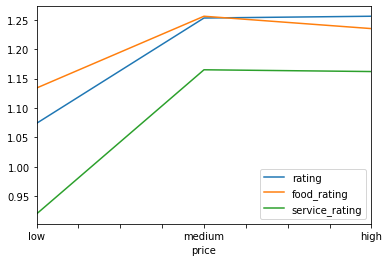

In [53]:
price_rating.plot()

We can observe that lower-priced restaurants get lower average ratings overall than other types of places, but high-priced restaurants do not get higher ratings than medium-prices ones.